# Etude, mise en forme de la base sur les logements

L'enquête logement de l'Insee nous renseigne sur les données relatifs à l'habitation et à la population de chaque commune. En particulier une variable a attiré notre attention : `P18_PMEN_ANEM0002` à savoir la population des ménages en 2018 ayant emménagé il y a moins de deux ans (entre 2016 et 2018) dans la commune. Ainsi, cette variable traduit selon nous en partie l'attractivité d'une commune par rapport à une autre. En effet, contrairement à la variable `P18_MPEN` qui donne la population totale des ménages, elle ne prends pas en compte l'accroissement naturelle de la population (à savoir les décès et les naissances). Nous chercherons donc par la suite à la prédire par des variables explicatives.

Dans ce notebook, nous étudirons ainsi les variables intéressantes du logement par rapport au sujet des mobilités résidentielles.

In [1]:
import pandas as pd
import xlrd 
import matplotlib.pyplot as plt
from math import log
import seaborn as sns
import numpy as np

In [2]:
#Importation de la base de données des logements
df_logement = pd.read_csv("./base-cc-logement-2018.csv", sep = ";", low_memory=False)

#Importation d'une table de correspondance pour avoir le nom des département avec leur chiffre
table_correspondance = pd.read_csv("./departements-francais.csv", sep  = "\t")[0:96]

,NUMÉRO,NOM,REGION,CHEF LIEU,SUPERFICIE (km²),POPULATION,DENSITE (habitants/km2)
0,1,Ain,Auvergne-Rhône-Alpes,Bourg-en-Bresse,5762.0,631877.0,109.7
1,2,Aisne,Hauts-de-France,Laon,7369.0,538659.0,73.1
2,3,Allier,Auvergne-Rhône-Alpes,Moulins,7340.0,341613.0,46.5
3,4,Alpes-de-Haute-Provence,Provence-Alpes-Côte d'Azur,Digne,6925.0,161799.0,23.4
4,5,Hautes-Alpes,Provence-Alpes-Côte d'Azur,Gap,5549.0,140916.0,25.4
...,...,...,...,...,...,...,...
91,91,Essonne,Ile-de-France,Évry,1804.0,1276233.0,707.3
92,92,Hauts-de-Seine,Ile-de-France,Nanterre,176.0,1601569.0,9120.6
93,93,Seine-St-Denis,Ile-de-France,Bobigny,236.0,1592663.0,6742.9
94,94,Val-de-Marne,Ile-de-France,Créteil,245.0,1372389.0,5601.6


In [3]:
#On remanie la table de correspondance pour qu'elle puisse être fusionné par la suite
for i in range(len(table_correspondance)):
    if len(table_correspondance['NUMÉRO'][i])==1:
           table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]
            
table_correspondance = table_correspondance.rename(columns = {'NUMÉRO' : "DEP"})[["DEP",'NOM']]
table_correspondance

<ipython-input-3-f1dcaddf5e45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_correspondance['NUMÉRO'][i] = "0" + table_correspondance['NUMÉRO'][i]


,DEP,NOM
0,01,Ain
1,02,Aisne
2,03,Allier
3,04,Alpes-de-Haute-Provence
4,05,Hautes-Alpes
...,...,...
91,91,Essonne
92,92,Hauts-de-Seine
93,93,Seine-St-Denis
94,94,Val-de-Marne


In [4]:
#Création d'une nouvelle colonne 'DEP' pour pouvoir agréger les données par département
df_logement['DEP']=df_logement['CODGEO'].str[:2]

df = df_logement.groupby('DEP').sum().reset_index()

#Jointure pour les noms des départements
df = df.merge(table_correspondance ,how = "left").set_index('DEP')




In [5]:
df

,P18_LOG,P18_RP,P18_RSECOCC,P18_LOGVAC,P18_MAISON,P18_APPART,P18_RP_1P,P18_RP_2P,P18_RP_3P,P18_RP_4P,...,P08_RP_TTEGOU,P08_RP_GARL,P08_RP_VOIT1P,P08_RP_VOIT1,P08_RP_VOIT2P,P08_RP_HABFOR,P08_RP_CASE,P08_RP_MIBOIS,P08_RP_MIDUR,NOM
DEP,,,,,,,,,,,,,,,,,,,,,
01,317983.076447,274538.375368,17582.922701,25861.778379,201245.717768,114247.435494,7369.145461,25735.301722,49320.341418,73277.205828,...,0.000000,175537.915132,210761.118146,103181.882498,107579.235648,0.000000,0.000000,0.000000,0.000000,Ain
02,266640.926339,231215.055899,9414.645126,26011.225313,201727.848075,62782.143121,5426.132009,17814.756456,40909.759309,62637.384661,...,0.000000,133288.770854,180944.213815,105255.847843,75688.365972,0.000000,0.000000,0.000000,0.000000,Aisne
03,208375.028618,162853.779701,15038.175956,30483.072961,149707.029893,57168.325324,4538.240573,15284.093627,34794.731431,47364.829694,...,0.000000,107064.756528,131920.892234,75173.272015,56747.620219,0.000000,0.000000,0.000000,0.000000,Allier
04,129062.084660,78089.671174,40196.730433,10775.683053,78587.926992,48992.409555,2653.180103,8345.656737,19159.524189,23502.575893,...,0.000000,47595.950766,60650.533494,34254.425307,26396.108187,0.000000,0.000000,0.000000,0.000000,Alpes-de-Haute-Provence
05,136581.166248,66428.288308,62181.601413,7971.276526,58993.655160,76550.150769,2143.818712,7873.261326,15332.698099,18925.439755,...,0.000000,41898.183005,51610.893626,29554.411525,22056.482101,0.000000,0.000000,0.000000,0.000000,Hautes-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,801736.785972,719924.794049,29878.111326,51933.880597,90617.111459,699698.238069,91622.205146,171441.051621,209382.984122,140825.400491,...,0.000000,363097.848866,465747.042765,352346.106814,113400.935951,0.000000,0.000000,0.000000,0.000000,Hauts-de-Seine
93,679663.108067,632024.931575,7492.635497,40145.540996,160062.858188,507011.480412,65331.658362,138331.565395,195887.555798,141065.086145,...,0.000000,282635.020367,368495.422234,279099.757422,89395.664812,0.000000,0.000000,0.000000,0.000000,Seine-St-Denis
94,640016.489385,592118.056979,11675.602451,36222.829955,137602.735087,490848.184668,60235.605545,124603.253527,177596.484530,130767.301441,...,0.000000,296375.513520,388808.103271,283564.112227,105243.991043,0.000000,0.000000,0.000000,0.000000,Val-de-Marne


In [27]:
#Exportations des résultats
df.drop("97", axis = 0, inplace = True)
df[["P18_PMEN", "NOM"]].to_csv(r"./Pop_dep_2018.csv")
df[["P18_PMEN_ANEM0002", "NOM"]].to_csv(r'./Nb_arrive_16-18.csv')

# Statistiques descriptives sur les données de logements

## 1. Dynamisme de la population

On peut observer la part de la population des ménages en 2018 qui est arrivé il y a moins de 2ans sur la population totale des ménages. Une part forte serait révélateur d'un fort dynamisme du département soit parce que beaucoup quitte le département soit parce que beaucoup y aménage relativement à la population.



In [7]:
df_PROP_MEN = df[["P18_PMEN", "P18_PMEN_ANEM0002", "P18_PMEN_ANEM0204", "P18_PMEN_ANEM0509", "P18_PMEN_ANEM10P","NOM"]]

df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_0509"] = df_PROP_MEN["P18_PMEN_ANEM0509"]/df_PROP_MEN["P18_PMEN"]*100
df_PROP_MEN["P18_PMEN_PROP_10P"] = df_PROP_MEN["P18_PMEN_ANEM10P"]/df_PROP_MEN["P18_PMEN"]*100



<ipython-input-7-8326e63e91c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0002"] = df_PROP_MEN["P18_PMEN_ANEM0002"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-7-8326e63e91c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PROP_MEN["P18_PMEN_PROP_0204"] = df_PROP_MEN["P18_PMEN_ANEM0204"]/df_PROP_MEN["P18_PMEN"]*100
<ipython-input-7-8326e63e91c3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

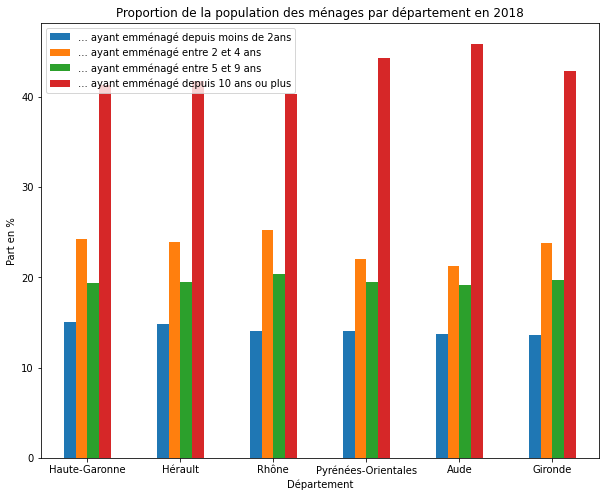

In [8]:
df_PROP_MEN_5P = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head(6)[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5P.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_0002", ascending = False).head(6)['NOM']
ax  = df_PROP_MEN_5P.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)

# Change the axes labels
ax.set_xlabel("Département")
ax.set_ylabel("Part en %")
ax.xaxis.set_ticklabels(legend)
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()


A priori les département de Haute-Garonne, Hérault, Rhône, Pyrénées-Orientales,Aude et Gironde ont le plus attiré le plus de personnes entre 2016 et 2018 comparativement à leur population. 

Sur une carte il s'agit de département située dans le sud du pays (Haute-Garonne, Hérault, Pyrénées-Orientales et Aude sont tous situés au niveau des Pyrénées) et plutôt vers de grosses agglomérations (Toulouse pour la Haute-Garonne, Lyon pour le Rhône).

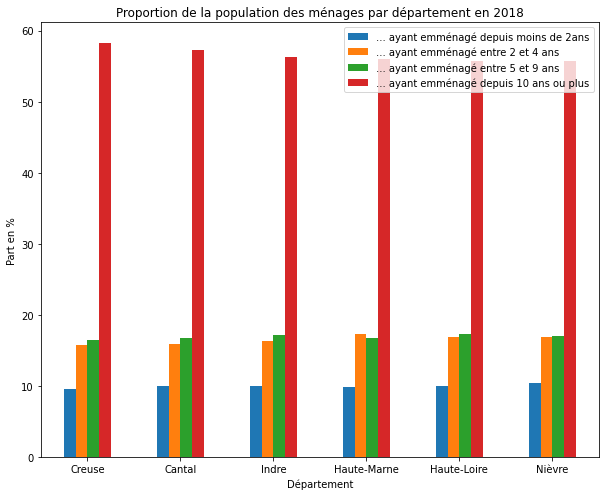

In [104]:
df_PROP_MEN_5D = df_PROP_MEN.sort_values("P18_PMEN_PROP_10P", ascending = False).head(6)[["P18_PMEN_PROP_0002", "P18_PMEN_PROP_0204", "P18_PMEN_PROP_0509", "P18_PMEN_PROP_10P"]] 
df_PROP_MEN_5D.columns = ["... ayant emménagé depuis moins de 2ans", "... ayant emménagé entre 2 et 4 ans", "... ayant emménagé entre 5 et 9 ans", "... ayant emménagé depuis 10 ans ou plus"]
legend = df_PROP_MEN.sort_values("P18_PMEN_PROP_10P", ascending = False).head(6)["NOM"]
ax  = df_PROP_MEN_5D.plot(kind = "bar")
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(10, 8)
# Change the axes labels
ax.set_xlabel("Département")
ax.xaxis.set_ticklabels(legend)
ax.set_ylabel("Part en %")
plt.xticks(rotation = 'horizontal')
plt.title("Proportion de la population des ménages par département en 2018")
plt.show()


In [105]:
df_PROP_MEN.mean()

<ipython-input-105-87f6fcdd7745>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_PROP_MEN.mean()


P18_PMEN              708632.874843
P18_PMEN_ANEM0002      83795.177514
P18_PMEN_ANEM0204     148616.644691
P18_PMEN_ANEM0509     137469.754771
P18_PMEN_ANEM10P      338751.297866
P18_PMEN_PROP_0002        11.530751
P18_PMEN_PROP_0204        19.859871
P18_PMEN_PROP_0509        18.902266
P18_PMEN_PROP_10P         49.707112
dtype: float64

A l'inverse ces 6 départements ont une population qui se renouvelle très peu : presque 60% de leur population s'est installé avant 2008 (alors que la moyenne est à 49,7%) et environ 10% s'est installé entre 2016 et 2018 (11,5% en moyenne sur les départements).

## 2. Les départements "pleins" attirent-ils plus ? 


In [76]:
#
df_PMEN = df.sort_values("P13_PMEN", ascending = False)[["P13_PMEN", "NOM"]].reset_index()
df_PMEN['Classement_PMEN'] = df_PMEN.index + 1

df_ANEM0002 = df.sort_values("P18_PMEN_ANEM0002", ascending = False)[["P18_PMEN_ANEM0002", "NOM"]].reset_index()
df_ANEM0002["Classement_ANEM0002"] = df_ANEM0002.index + 1 

df_ANEM0204 = df.sort_values("P18_PMEN_ANEM0204", ascending = False)[["P18_PMEN_ANEM0204", "NOM"]].reset_index()
df_ANEM0204['Classement_ANEM0204'] = df_ANEM0204.index + 1 

df_comp = df_PMEN.merge(df_ANEM0002, how = "left")
df_comp = df_comp.merge(df_ANEM0204, how = "left")

df_comp[["DEP", "NOM" ,"Classement_PMEN", "Classement_ANEM0002", "Classement_ANEM0204"]].head(30)

,DEP,NOM,Classement_PMEN,Classement_ANEM0002,Classement_ANEM0204
0,75,Paris,1,1,1
1,13,Bouches-du-Rhône,2,2,2
2,59,Nord,3,4,4
3,69,Rhône,4,3,3
4,92,Hauts-de-Seine,5,8,6
5,93,Seine-St-Denis,6,10,7
6,33,Gironde,7,5,5
7,62,Pas-de-Calais,8,13,13
8,78,Yvelines,9,14,11
9,77,Seine-et-Marne,10,15,12


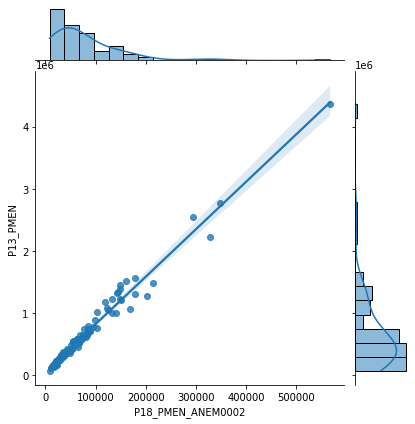

In [100]:
ax = sns.jointplot(y = "P13_PMEN",x= "P18_PMEN_ANEM0002", data=df, kind='reg')

En créant un classement des départements en fonction de leur population en 2013 `Classement_PMEN`, du nombre de personne ayant emménagées entre 2016 et 2018 `Classement_ANEM0002` et ayant emménagées entre 2014 et 2016 `Classement_ANEM0204`, on s'aperçoit que globalement les départements déjà bien peuplés en 2013 sont ceux qui attirent globalement le plus de personne les années suivantes (Paris toujours en premier suivi des Bouches-du-Rhône, du Nord et du Rhône). De plus, en observant le nuage de point ci-dessus, on observe aussi bien cette tendance. 

Toutefois, on peut remarquer quelques changements dans les classements : la Seine-St-Denis, les Yvelines, le Pas-de-Calais, les Haut-de-Seine, le Val-de-Marne sont moins bien classés s'agissant des arrivées entre 2016 et 2018 que dans le classement par population. A l'inverse la Gironde, la Loire-Atlantique et la Gironde attire bien plus par rapport au classement par population.

Donc oui en moyenne les départements très peuplés attirent comparativement plus de personne mais on observe tout de même certains changements de classement qui montre l'attractivité de certains territoires par rapport à d'autres. Mais cela n'explique en rien les raisons de leur attractivité passé et d'aujourd'hui.